In [169]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_training_data, load_test_data, split_data
import networkx as nx
import time, datetime
from utils import plot_graph

from n_walk import product_graph, graph_product, graph_product_el, get_labels_nodes
import kernel_class as kc
import kernel_methods as km

from importlib import reload

In [2]:
graphs, labels =  load_training_data()
submi_graphs = load_test_data()

# Test of graph product

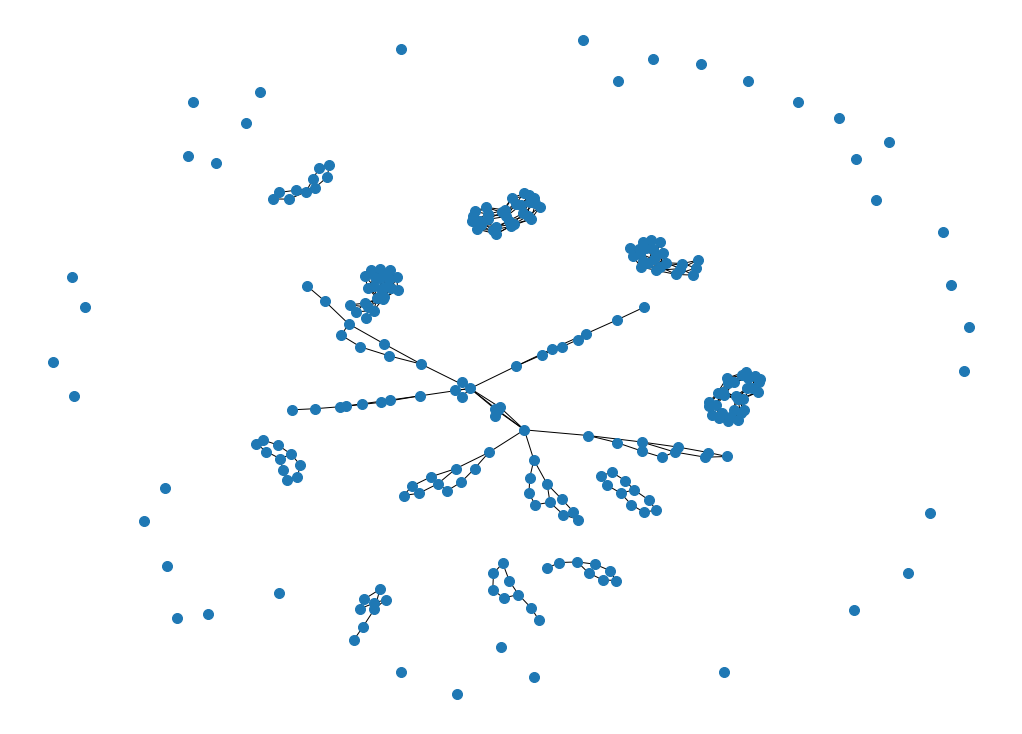

In [3]:
g1, g2 = graphs[:2]
plt.figure(figsize=(14, 10))
gp = product_graph(g1, g2)
nx.draw(gp, node_size = 100)

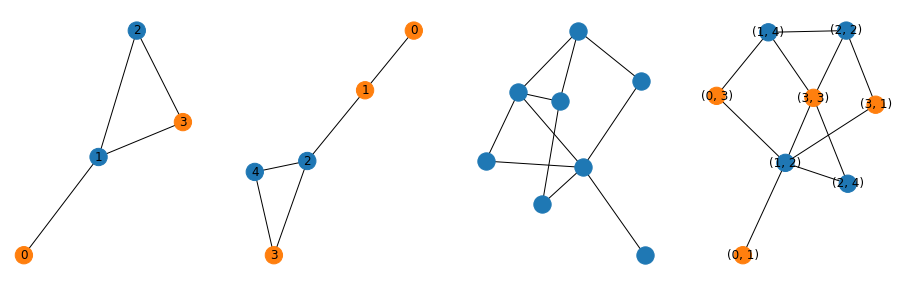

In [13]:
ga = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3)])
for v, l in zip(range(4), [0, 1, 1, 0]) : ga.nodes[v]["labels"] = [l]
gb = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 2)])
for v, l in zip(range(5), [0, 0, 1, 0, 1]) : gb.nodes[v]["labels"] = [l]

plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plot_graph(ga)
plt.subplot(1, 5, 2)
plot_graph(gb)
plt.subplot(1, 5, 3)
gp = product_graph(ga, gb)
initial_nodes = dict(gp.nodes)
for v in initial_nodes:
    if len(gp.edges(v))==0:
        gp.remove_node(v)
nx.draw(gp)
plt.subplot(1, 5, 4)
plot_graph(graph_product(ga, gb, with_lonely_nodes=False))

# Test product graph speed

In [14]:
np.random.seed(42)
g1_indices = np.random.choice(len(graphs), 6000, replace=True)
g2_indices = np.random.choice(len(graphs), 6000, replace=True)

def convert_time(seconds_tot):
    seconds = int(seconds_tot%60)
    minutes_tot = int(seconds_tot//60)
    if minutes_tot == 0: return f"{seconds}s"
    minutes = minutes_tot%60
    hours = int(minutes_tot//60)
    if hours == 0: return f"{minutes}m {seconds}s"
    return f"{hours}h {minutes}m {seconds}s"


def test_speed_one_graph(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g = graphs[g1_indices[i*n_in + j]]
            f(g, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

def test_speed_two_graphs(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g1 = graphs[g1_indices[i*n_in + j]]
            g2 = graphs[g2_indices[i*n_in + j]]
            f(g1, g2, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

In [20]:
from n_walk import product_graph, graph_product, graph_product_el
d = test_speed_two_graphs(product_graph)

19h 53m 43s ,  4h 4m 1s


In [21]:
d = test_speed_two_graphs(graph_product)

7h 57m 43s ,  2h 39m 12s


In [22]:
d = test_speed_two_graphs(graph_product, with_lonely_nodes=False)

5h 53m 40s ,  59m 27s


In [23]:
d = test_speed_two_graphs(graph_product_el)

8h 9m 12s ,  2h 54m 24s


In [24]:
d = test_speed_two_graphs(graph_product_el, with_lonely_nodes=False)

4h 41m 6s ,  1h 14m 44s


# Test of Random Walk Kernel and its acceleration.

In [318]:
sub_graphs, sub_labels = split_data(n_splits=3)[0]
souby = sub_graphs[:20]

100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


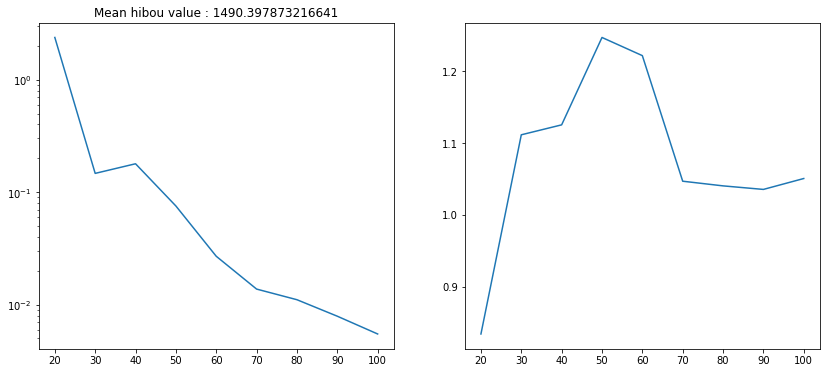

In [341]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


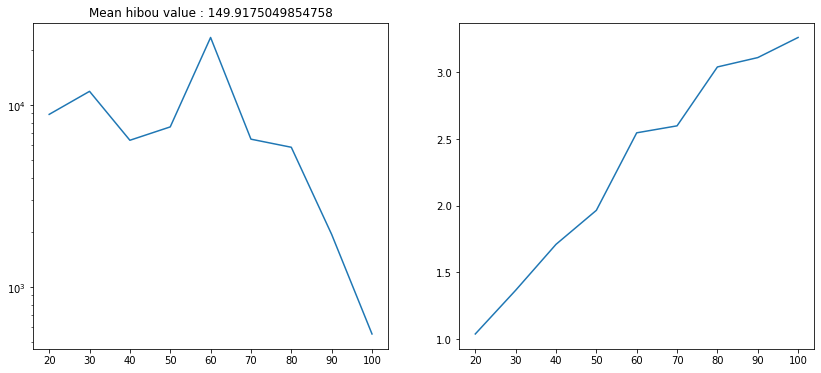

In [343]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)

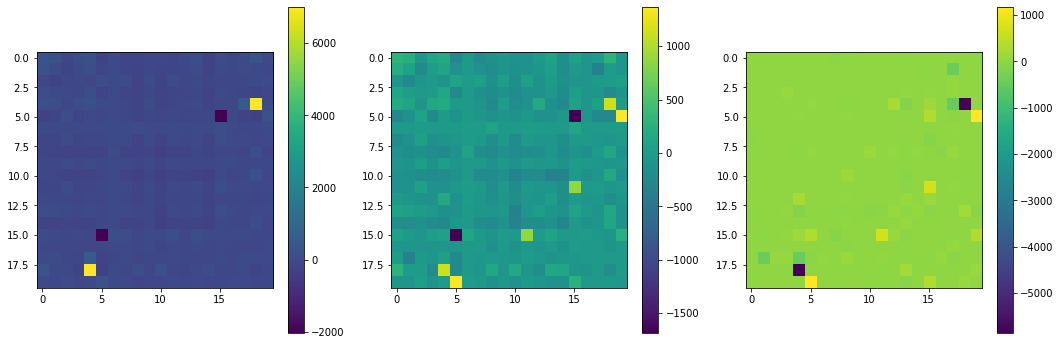

In [335]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(hibou_souby)
plt.colorbar()
plt.subplot(132)
plt.imshow(aigle_souby)
plt.colorbar()
plt.subplot(133)
plt.imshow(aigle_souby - hibou_souby)
plt.colorbar()

# With grakel

In [227]:
from grakel import RandomWalkLabeled, RandomWalk

In [228]:
rwgk = RandomWalkLabeled(lamda=0.95, method_type='fast')
gs = [nx.adjacency_matrix(g).toarray() for g in sub_graphs[:2]]
nls = [[x[0] for x in nx.get_node_attributes(g, "labels").values()] for g in sub_graphs[:2]]

In [230]:
rwgk.fit_transform(zip(gs, nls))

array([[696.12183612, 701.7062002 ],
       [701.7062002 , 792.52322656]])

In [115]:
mlkj = rwgk.fit_transform(zip(gs, nls))